### Product Catalog EDA Implementation
#### Comprehensive Analysis for Product Portfolio & Vendor Management

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [27]:
data_path = 'product_catlog.csv' 
data_path

'product_catlog.csv'

In [30]:
# Load data
df = pd.read_csv(data_path, low_memory=False)
print(f"Data loaded successfully from '{data_path}'")
print(f"Dataset shape: {df.shape}")

Data loaded successfully from 'product_catlog.csv'
Dataset shape: (10, 77)


In [82]:
df.head()

,item_nbr,old_nbr,sbu_nbr,sbu_desc,division_nbr,division_desc,dept_nbr,dept_desc,dept_category_group_nbr,dept_category_group_desc,...,price_segment,is_active,is_national_brand,is_private_label,sbu_desc_clean,division_desc_clean,dept_desc_clean,dept_category_desc_clean,dept_subcatg_desc_clean,margin_pct
0,270217,1535,40,GROCERY,28,SUPERCENTER GROCERY,1,CANDY,2202,D01 SEASON CONFECTION,...,Mid-tier,True,True,False,GROCERY,SUPERCENTER GROCERY,CANDY,D01 VALENTINES DAY,VAL BOX CHOCOLATE,43.161094
1,376715,2294,119,CONSUMABLES,1,"KENMART STORES, INC",2,HBA,1670,D02 ORAL FEM HYGENE,...,Mid-tier,True,True,False,CONSUMABLES,"KENMART STORES, INC",HBA,D02 ORAL CARE,DENTURE CLEAN ADHESIVES,24.498416
2,393119,2701,119,CONSUMABLES,1,"KENMART STORES, INC",2,HBA,2328,D02 SHAVE PERSONAL CARE,...,Mid-tier,True,True,False,CONSUMABLES,"KENMART STORES, INC",HBA,D02 WET SHAVE AND MENS TOILETRIES,WET SHAVE MEN TOILETRIES,21.663620
3,512882,2917,119,CONSUMABLES,1,"KENMART STORES, INC",2,HBA,1670,D02 ORAL FEM HYGENE,...,Mid-tier,True,True,False,CONSUMABLES,"KENMART STORES, INC",HBA,D02 ORAL CARE,TOOTHPASTE,28.808023
4,329934,8559,119,CONSUMABLES,1,"KENMART STORES, INC",8,PET SUPPLIES,2203,D08 CAT CONSUMABLES,...,Value,True,False,True,CONSUMABLES,"KENMART STORES, INC",PET SUPPLIES,D08 CAT FOOD,WET CAT,32.398876


In [32]:
# Convert numeric columns
numeric_columns = [
    'item_nbr', 'old_nbr', 'sbu_nbr', 'division_nbr', 'dept_nbr',
    'dept_category_group_nbr', 'dept_category_nbr', 'dept_subcatg_nbr',
    'fineline_nbr', 'brand_id', 'vendor_id', 'buyer_id', 'director_id',
    'cost', 'base_unit_retail_amt', 'sell_qty', 'brand_family_id'
]

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
print("Converted specified columns to numeric types.")

Converted specified columns to numeric types.


In [33]:
# Create derived metrics
# Pricing metrics
if all(col in df.columns for col in ['cost', 'base_unit_retail_amt']):
    df['margin_dollars'] = df['base_unit_retail_amt'] - df['cost']
    df['margin_percent'] = (df['margin_dollars'] / df['base_unit_retail_amt'] * 100).fillna(0)
    print("Created derived metrics: 'margin_dollars', 'margin_percent'")

Created derived metrics: 'margin_dollars', 'margin_percent'


In [36]:
# Price segments
if 'base_unit_retail_amt' in df.columns:
    df['price_segment'] = pd.cut(
        df['base_unit_retail_amt'].fillna(0),
        bins=[0, 5, 15, 50, float('inf')],
        labels=['Value', 'Mid-tier', 'Premium', 'Luxury']
    )
    print("Created derived metric: 'price_segment'")

Created derived metric: 'price_segment'


*   **What it does:** This code takes a continuous numerical value (the price) and converts it into a discrete category (a price segment). This is a common technique called **binning** or **discretization**.
*   **Does it make sense?** **Yes, absolutely.** It's a very powerful way to simplify analysis. Instead of dealing with hundreds of different price points, you can analyze product performance across a few, well-defined segments.
*   **Breakdown:**
    *   `pd.cut(...)`: This is the perfect pandas function for this job.
    *   `df['base_unit_retail_amt'].fillna(0)`: It handles missing prices by treating them as 0, which correctly places them in the 'Value' segment. This is a sensible default.
    *   `bins=[0, 5, 15, 50, float('inf')]`: This defines the boundaries for your segments. For example, any price between 5.01 and 15.00 will be labeled 'Mid-tier'. The use of `float('inf')` is the correct way to specify an upper bound that includes all numbers above 50.
    *   `labels=[...]`: These are the human-readable names for your new categories.

**Conclusion:** This is a standard and very effective way to create categorical price tiers, which is extremely useful for strategic analysis.

In [38]:
# Product status indicators
if 'item_status_code' in df.columns:
    df['is_active'] = df['item_status_code'] == 'A'
    print("Created derived metric: 'is_active'")

Created derived metric: 'is_active'


*   **What it does:** It creates a new column `is_active` that will contain either `True` or `False`. It will be `True` if the `item_status_code` for that row is 'A', and `False` otherwise.
*   **Does it make sense?** **Yes, this is a perfect use of boolean masking.** It's the most efficient and readable way to create a flag. This new boolean column is much easier to work with than the original character code. For example, you can now easily calculate the number of active products with `df['is_active'].sum()`, because in Python, `True` is treated as `1` and `False` is treated as `0` in arithmetic operations.

**Conclusion:** This is the standard, Pythonic way to convert a status code into a more useful boolean flag.

In [40]:
# Brand type indicators
if 'brand_type' in df.columns:
    df['is_national_brand'] = df['brand_type'] == 'NB'
    df['is_private_label'] = df['brand_type'] == 'PL'
    print("Created derived metrics: 'is_national_brand', 'is_private_label'")

Created derived metrics: 'is_national_brand', 'is_private_label'


*   **What it does:** Similar to the `is_active` flag, this creates two new boolean columns. `is_national_brand` will be `True` only when `brand_type` is 'NB', and `is_private_label` will be `True` only when it's 'PL'.
*   **Does it make sense?** **Yes, this is also a great approach.** Creating separate indicator columns (also known as "dummy variables") for important categories is a fundamental step in data preparation for both analysis and machine learning. It allows you to easily filter, group, and compare these brand types. For example, you could compare the average margin of national vs. private label brands very easily:
    *   `df.groupby('is_private_label')['margin_percent'].mean()`

**Conclusion:** All three calculations are not only correct but are also examples of good practice in data analysis and feature engineering. They transform raw data into new features that are much easier to interpret and use in subsequent analytical steps.

In [ ]:
# Create derived metrics
# Pricing metrics
if all(col in df.columns for col in ['cost', 'base_unit_retail_amt']):
    df['margin_dollars'] = df['base_unit_retail_amt'] - df['cost']
    df['margin_percent'] = (df['margin_dollars'] / df['base_unit_retail_amt'] * 100).fillna(0)
    print("\n✅ Created derived metrics: 'margin_dollars', 'margin_percent'")
    
# Price segments
if 'base_unit_retail_amt' in df.columns:
    df['price_segment'] = pd.cut(
        df['base_unit_retail_amt'].fillna(0),
        bins=[0, 5, 15, 50, float('inf')],
        labels=['Value', 'Mid-tier', 'Premium', 'Luxury']
    )
    print("✅ Created derived metric: 'price_segment'")
    
# Product status indicators
if 'item_status_code' in df.columns:
    df['is_active'] = df['item_status_code'] == 'A'
    print("✅ Created derived metric: 'is_active'")
    
# Brand type indicators
if 'brand_type' in df.columns:
    df['is_national_brand'] = df['brand_type'] == 'NB'
    df['is_private_label'] = df['brand_type'] == 'PL'
    print("✅ Created derived metrics: 'is_national_brand', 'is_private_label'")
    
# Category hierarchy levels
hierarchy_cols_setup = ['sbu_desc', 'division_desc', 'dept_desc', 
                 'dept_category_desc', 'dept_subcatg_desc']
for col in hierarchy_cols_setup:
    if col in df.columns:
        df[f'{col}_clean'] = df[col].fillna('Unknown').astype(str)
print("✅ Cleaned category hierarchy columns.")

In [15]:
def __init__(self, data_path):
    """Initialize with data loading and preparation"""
    self.df = self.load_and_prepare_data(data_path)
    self.setup_analysis_variables()
    
def load_and_prepare_data(self, data_path):
    """Load and prepare the product catalog dataset"""
    # Load data
    df = pd.read_csv('product_catlog', low_memory=False)
    
    # Convert numeric columns
    numeric_columns = [
        'item_nbr', 'old_nbr', 'sbu_nbr', 'division_nbr', 'dept_nbr',
        'dept_category_group_nbr', 'dept_category_nbr', 'dept_subcatg_nbr',
        'fineline_nbr', 'brand_id', 'vendor_id', 'buyer_id', 'director_id',
        'cost', 'base_unit_retail_amt', 'sell_qty', 'brand_family_id'
    ]
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Create derived metrics
    self.create_derived_metrics(df)
    
    return df

In [16]:
def create_derived_metrics(self, df):
    """Create business-relevant derived metrics"""
    # Pricing metrics
    if all(col in df.columns for col in ['cost', 'base_unit_retail_amt']):
        df['margin_dollars'] = df['base_unit_retail_amt'] - df['cost']
        df['margin_percent'] = (df['margin_dollars'] / df['base_unit_retail_amt'] * 100).fillna(0)
        
    # Price segments
    if 'base_unit_retail_amt' in df.columns:
        df['price_segment'] = pd.cut(
            df['base_unit_retail_amt'].fillna(0),
            bins=[0, 5, 15, 50, float('inf')],
            labels=['Value', 'Mid-tier', 'Premium', 'Luxury']
        )
        
    # Product status indicators
    if 'item_status_code' in df.columns:
        df['is_active'] = df['item_status_code'] == 'A'
        
    # Brand type indicators
    if 'brand_type' in df.columns:
        df['is_national_brand'] = df['brand_type'] == 'NB'
        df['is_private_label'] = df['brand_type'] == 'PL'
        
    # Category hierarchy levels
    hierarchy_cols = ['sbu_desc', 'division_desc', 'dept_desc', 
                     'dept_category_desc', 'dept_subcatg_desc']
    for col in hierarchy_cols:
        if col in df.columns:
            df[f'{col}_clean'] = df[col].fillna('Unknown').astype(str)

In [17]:
def setup_analysis_variables(self):
    """Setup key variables for analysis"""
    self.numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
    self.categorical_cols = self.df.select_dtypes(include=['object']).columns.tolist()
    
    # Key business dimensions
    self.hierarchy_cols = ['sbu_desc', 'division_desc', 'dept_desc', 
                          'dept_category_desc', 'dept_subcatg_desc', 'fineline_desc']
    self.vendor_cols = ['vendor_name', 'vendor_id']
    self.brand_cols = ['brand_name', 'brand_family_name', 'brand_type']
    self.pricing_cols = ['cost', 'base_unit_retail_amt', 'margin_dollars', 'margin_percent']
    self.operational_cols = ['buyer_name', 'item_status_code', 'country_name']

#### LEVEL 1: BASIC EDA CHECKS

In [18]:
def level_1_basic_analysis(self):
    """Complete Level 1: Basic Product Catalog Analysis"""
    print("="*60)
    print("LEVEL 1: BASIC PRODUCT CATALOG ANALYSIS")
    print("="*60)
    
    self.basic_portfolio_overview()
    self.basic_category_structure()
    self.basic_vendor_brand_landscape()
    self.basic_pricing_overview()
    self.basic_quality_assessment()
    
    print("\n✅ LEVEL 1 BASIC ANALYSIS COMPLETED")

In [19]:
def basic_portfolio_overview(self):
    """1.1 Product Portfolio Overview"""
    print("\n📦 1.1 PRODUCT PORTFOLIO OVERVIEW")
    print("-" * 40)
    
    # Dataset dimensions
    total_products = len(self.df)
    unique_upcs = self.df['upc'].nunique() if 'upc' in self.df.columns else 0
    
    print(f"Portfolio Size:")
    print(f"  Total Products (SKUs): {total_products:,}")
    print(f"  Unique UPCs: {unique_upcs:,}")
    
    # Product status distribution
    if 'item_status_code' in self.df.columns:
        status_dist = self.df['item_status_code'].value_counts()
        print(f"\nProduct Status Distribution:")
        for status, count in status_dist.items():
            percentage = count / total_products * 100
            print(f"  {status}: {count:,} ({percentage:.1f}%)")
            
    # Active vs inactive
    if 'is_active' in self.df.columns:
        active_count = self.df['is_active'].sum()
        inactive_count = total_products - active_count
        print(f"\nActive vs Inactive:")
        print(f"  Active Products: {active_count:,} ({active_count/total_products*100:.1f}%)")
        print(f"  Inactive Products: {inactive_count:,} ({inactive_count/total_products*100:.1f}%)")
        
    # Geographic sourcing
    if 'country_name' in self.df.columns:
        country_dist = self.df['country_name'].value_counts().head()
        print(f"\nTop Source Countries:")
        print(country_dist)

In [20]:
def basic_category_structure(self):
    """1.2 Category Structure Analysis"""
    print("\n🏗️ 1.2 CATEGORY STRUCTURE ANALYSIS")
    print("-" * 40)
    
    # Hierarchy depth analysis
    for i, col in enumerate(self.hierarchy_cols):
        if col in self.df.columns:
            unique_count = self.df[col].nunique()
            level_name = col.replace('_desc', '').replace('_', ' ').title()
            print(f"  Level {i+1} - {level_name}: {unique_count} categories")
            
    # Department distribution
    if 'dept_desc' in self.df.columns:
        dept_dist = self.df['dept_desc'].value_counts().head(10)
        print(f"\nTop 10 Departments by Product Count:")
        print(dept_dist)
        
    # Category concentration
    if 'dept_category_desc' in self.df.columns:
        category_dist = self.df['dept_category_desc'].value_counts()
        top_5_categories = category_dist.head(5)
        top_5_share = top_5_categories.sum() / total_products * 100
        
        print(f"\nCategory Concentration:")
        print(f"  Top 5 categories contain {top_5_share:.1f}% of products")
        print(top_5_categories)

In [21]:
def basic_vendor_brand_landscape(self):
    """1.3 Vendor & Brand Landscape"""
    print("\n🏭 1.3 VENDOR & BRAND LANDSCAPE")
    print("-" * 40)
    
    # Vendor analysis
    if 'vendor_name' in self.df.columns:
        unique_vendors = self.df['vendor_name'].nunique()
        top_vendors = self.df['vendor_name'].value_counts().head(10)
        
        print(f"Vendor Portfolio:")
        print(f"  Total Unique Vendors: {unique_vendors:,}")
        print(f"\nTop 10 Vendors by Product Count:")
        print(top_vendors)

    # Brand analysis
    if 'brand_name' in self.df.columns:
        unique_brands = self.df['brand_name'].nunique()
        top_brands = self.df['brand_name'].value_counts().head(10)
        
        print(f"\nBrand Portfolio:")
        print(f"  Total Unique Brands: {unique_brands:,}")
        print(f"\nTop 10 Brands by Product Count:")
        print(top_brands)
        
    # Brand type distribution
    if 'brand_type' in self.df.columns:
        brand_type_dist = self.df['brand_type'].value_counts()
        print(f"\nBrand Type Distribution:")
        for brand_type, count in brand_type_dist.items():
            percentage = count / len(self.df) * 100
            print(f"  {brand_type}: {count:,} ({percentage:.1f}%)")

In [22]:
def basic_pricing_overview(self):
    """1.4 Basic Pricing Overview"""
    print("\n💰 1.4 PRICING OVERVIEW")
    print("-" * 40)
    
    # Price distribution
    if 'base_unit_retail_amt' in self.df.columns:
        price_summary = self.df['base_unit_retail_amt'].describe()
        print("Retail Price Distribution:")
        print(price_summary.round(2))
        
    # Cost distribution
    if 'cost' in self.df.columns:
        cost_summary = self.df['cost'].describe()
        print(f"\nCost Distribution:")
        print(cost_summary.round(2))
        
    # Margin analysis
    if 'margin_percent' in self.df.columns:
        margin_summary = self.df['margin_percent'].describe()
        print(f"\nMargin Percentage Distribution:")
        print(margin_summary.round(2))
        
    # Price segments
    if 'price_segment' in self.df.columns:
        price_seg_dist = self.df['price_segment'].value_counts()
        print(f"\nPrice Segment Distribution:")
        print(price_seg_dist)

In [23]:
def basic_quality_assessment(self):
    """1.5 Data Quality Assessment"""
    print("\n🛡️ 1.5 DATA QUALITY ASSESSMENT")
    print("-" * 40)
    
    # Missing data analysis
    missing_data = self.df.isnull().sum()
    missing_percent = (missing_data / len(self.df)) * 100
    
    print("Missing Data Summary (Top 15):")
    missing_summary = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_percent.values
    }).sort_values('Missing_Percentage', ascending=False)
    
    print(missing_summary.head(15))
    
    # Critical field completeness
    critical_fields = ['item_description', 'dept_desc', 'vendor_name', 
                      'brand_name', 'base_unit_retail_amt', 'cost']
    
    print(f"\nCritical Field Completeness:")
    for field in critical_fields:
        if field in self.df.columns:
            completeness = (1 - self.df[field].isnull().mean()) * 100
            print(f"  {field}: {completeness:.1f}% complete")
            
    # Duplicates analysis
    if 'item_nbr' in self.df.columns:
        duplicates = self.df['item_nbr'].duplicated().sum()
        print(f"\nDuplicate Analysis:")
        print(f"  Duplicate item numbers: {duplicates}")
        
    # Data consistency checks
    print(f"\nData Consistency Checks:")
    
    # Negative prices/costs
    if 'base_unit_retail_amt' in self.df.columns:
        negative_prices = (self.df['base_unit_retail_amt'] < 0).sum()
        print(f"  Negative retail prices: {negative_prices}")
        
    if 'cost' in self.df.columns:
        negative_costs = (self.df['cost'] < 0).sum()
        print(f"  Negative costs: {negative_costs}")
        
    # Invalid margins
    if 'margin_percent' in self.df.columns:
        extreme_margins = ((self.df['margin_percent'] < -100) | (self.df['margin_percent'] > 100)).sum()
        print(f"  Extreme margins (>100% or <-100%): {extreme_margins}")

#### LEVEL 2: MEDIUM ANALYSIS

In [24]:
def level_2_medium_analysis(self):
    """Complete Level 2: Medium Analysis"""
    print("\n" + "="*60)
    print("LEVEL 2: MEDIUM-LEVEL ANALYSIS")
    print("="*60)
    
    self.medium_category_management()
    self.medium_vendor_analysis()
    self.medium_brand_analysis()
    self.medium_pricing_analysis()
    self.medium_operational_analysis()
    
    print("\n✅ LEVEL 2 MEDIUM ANALYSIS COMPLETED")

In [25]:
	def medium_category_management(self):
		"""2.1 Category Management Analysis"""
		print("\n📊 2.1 CATEGORY MANAGEMENT ANALYSIS")
		print("-" * 40)
		
		if 'dept_desc' in self.df.columns:
			# Department analysis
			dept_analysis = self.df.groupby('dept_desc').agg({
				'item_nbr': 'count',
				'base_unit_retail_amt': ['mean', 'median', 'std'] if 'base_unit_retail_amt' in self.df.columns else lambda x: None,
				'margin_percent': 'mean' if 'margin_percent' in self.df.columns else lambda x: None,
				'is_active': 'sum' if 'is_active' in self.df.columns else lambda x: None
			}).round(2)
			
			dept_analysis.columns = ['_'.join(col).strip() for col in dept_analysis.columns]
			dept_analysis = dept_analysis.sort_values(dept_analysis.columns[0], ascending=False)
			
			print("Department Analysis (Top 10):")
			print(dept_analysis.head(10))
			
			# Category breadth analysis
			if all(col in self.df.columns for col in ['dept_desc', 'dept_category_desc']):
				category_breadth = self.df.groupby('dept_desc')['dept_category_desc'].nunique().sort_values(ascending=False)
				
				print(f"\nCategory Breadth Analysis (Categories per Department):")
				print(category_breadth.head(10))
				
				# Identify departments with high/low complexity
				high_complexity = category_breadth[category_breadth > category_breadth.quantile(0.75)]
				low_complexity = category_breadth[category_breadth < category_breadth.quantile(0.25)]
				
				print(f"\nHigh Complexity Departments (>{category_breadth.quantile(0.75):.0f} categories):")
				print(high_complexity)
				
				print(f"\nLow Complexity Departments (<{category_breadth.quantile(0.25):.0f} categories):")
				print(low_complexity)
				
			# Visualize department distribution
			if len(dept_analysis) > 0:
				plt.figure(figsize=(15, 8))
				
				plt.subplot(2, 2, 1)
				top_depts = dept_analysis.head(15)
				plt.bar(range(len(top_depts)), top_depts.iloc[:, 0])
				plt.title('Product Count by Department (Top 15)')
				plt.xlabel('Department Rank')
				plt.ylabel('Product Count')
				plt.xticks(range(len(top_depts)), [
					# THIS IS WHERE YOUR CODE STOPS - HERE'S THE REST:
					
					dept[:15] + '...' if len(dept) > 15 else dept 
					for dept in top_depts.index
				], rotation=45, ha='right')
				
				# Average price by department
				if 'base_unit_retail_amt_mean' in dept_analysis.columns:
					plt.subplot(2, 2, 2)
					price_data = dept_analysis['base_unit_retail_amt_mean'].dropna().head(15)
					plt.bar(range(len(price_data)), price_data.values)
					plt.title('Average Price by Department (Top 15)')
					plt.xlabel('Department Rank')
					plt.ylabel('Average Price ($)')
					plt.xticks(range(len(price_data)), [
						dept[:15] + '...' if len(dept) > 15 else dept 
						for dept in price_data.index
					], rotation=45, ha='right')
					
				# Margin analysis by department
				if 'margin_percent_mean' in dept_analysis.columns:
					plt.subplot(2, 2, 3)
					margin_data = dept_analysis['margin_percent_mean'].dropna().head(15)
					plt.bar(range(len(margin_data)), margin_data.values)
					plt.title('Average Margin % by Department (Top 15)')
					plt.xlabel('Department Rank')
					plt.ylabel('Average Margin (%)')
					plt.xticks(range(len(margin_data)), [
						dept[:15] + '...' if len(dept) > 15 else dept 
						for dept in margin_data.index
					], rotation=45, ha='right')
					
				# Category complexity visualization
				if 'dept_category_desc' in self.df.columns:
					plt.subplot(2, 2, 4)
					complexity_data = category_breadth.head(15)
					plt.bar(range(len(complexity_data)), complexity_data.values)
					plt.title('Category Count by Department (Top 15)')
					plt.xlabel('Department Rank')
					plt.ylabel('Number of Categories')
					plt.xticks(range(len(complexity_data)), [
						dept[:15] + '...' if len(dept) > 15 else dept 
						for dept in complexity_data.index
					], rotation=45, ha='right')
				
				plt.tight_layout()
				plt.show()
				
			# Portfolio concentration analysis
			total_products = len(self.df)
			dept_counts = self.df['dept_desc'].value_counts()
			
			# Calculate cumulative percentage
			cumulative_products = dept_counts.cumsum()
			cumulative_percentage = cumulative_products / total_products * 100
			
			# Find departments contributing to 80% of products
			top_depts_80pct = cumulative_percentage <= 80
			num_top_depts = top_depts_80pct.sum()
			
			print(f"\nPortfolio Concentration Analysis:")
			print(f"  Top {num_top_depts} departments contain 80% of products ({num_top_depts/len(dept_counts)*100:.1f}% of departments)")
			print(f"  Bottom {len(dept_counts) - num_top_depts} departments contain 20% of products ({(len(dept_counts) - num_top_depts)/len(dept_counts)*100:.1f}% of departments)")
			
			# SKU density analysis
			if all(col in self.df.columns for col in ['dept_desc', 'dept_category_desc', 'dept_subcatg_desc']):
				sku_density = self.df.groupby('dept_desc').agg({
					'dept_category_desc': 'nunique',
					'dept_subcatg_desc': 'nunique',
					'item_nbr': 'count'
				})
				sku_density.columns = ['Categories', 'Subcategories', 'SKUs']
				sku_density['SKUs_per_Category'] = sku_density['SKUs'] / sku_density['Categories']
				sku_density['SKUs_per_Subcategory'] = sku_density['SKUs'] / sku_density['Subcategories']
				
				print(f"\nSKU Density Analysis (Top 10 by SKU count):")
				sku_density_sorted = sku_density.sort_values('SKUs', ascending=False)
				print(sku_density_sorted.head(10).round(1))
				
				# Identify departments with high SKU proliferation
				high_sku_density = sku_density[sku_density['SKUs_per_Category'] > sku_density['SKUs_per_Category'].quantile(0.75)]
				print(f"\nHigh SKU Proliferation Departments (SKU rationalization candidates):")
				print(high_sku_density.sort_values('SKUs_per_Category', ascending=False))
				
			# Category performance matrix
			if all(col in self.df.columns for col in ['dept_desc', 'base_unit_retail_amt', 'margin_percent']):
				category_matrix = self.df.groupby('dept_desc').agg({
					'item_nbr': 'count',
					'base_unit_retail_amt': 'mean',
					'margin_percent': 'mean'
				}).round(2)
				
				category_matrix.columns = ['Product_Count', 'Avg_Price', 'Avg_Margin']
				
				# Classify departments by volume and margin
				high_volume_threshold = category_matrix['Product_Count'].median()
				high_margin_threshold = category_matrix['Avg_Margin'].median()
				
				def classify_department(row):
					if row['Product_Count'] > high_volume_threshold and row['Avg_Margin'] > high_margin_threshold:
						return 'High Volume, High Margin'
					elif row['Product_Count'] > high_volume_threshold:
						return 'High Volume, Low Margin'
					elif row['Avg_Margin'] > high_margin_threshold:
						return 'Low Volume, High Margin'
					else:
						return 'Low Volume, Low Margin'
				
				category_matrix['Strategy_Classification'] = category_matrix.apply(classify_department, axis=1)
				
				print(f"\nDepartment Strategic Classification:")
				strategy_summary = category_matrix['Strategy_Classification'].value_counts()
				print(strategy_summary)
				
				# Show examples of each classification
				for strategy in strategy_summary.index:
					examples = category_matrix[category_matrix['Strategy_Classification'] == strategy].head(3)
					print(f"\n{strategy} Examples:")
					print(examples[['Product_Count', 'Avg_Price', 'Avg_Margin']])
					
		else:
			print("Required column 'dept_desc' not found for category management analysis")


1.  **`margin_dollars = df['base_unit_retail_amt'] - df['cost']`**
    *   **Purpose:** This calculates the gross profit for a single unit of a product in absolute currency terms (e.g., in dollars).
    *   **Logic:** It subtracts the cost of the item from its selling price. This is the fundamental definition of profit before any other operating expenses are considered.
    *   **Verdict:** Correct.

2.  **`margin_percent = (df['margin_dollars'] / df['base_unit_retail_amt'] * 100).fillna(0)`**
    *   **Purpose:** This calculates the gross margin as a percentage of the revenue. This is a critical KPI for understanding profitability.
    *   **Logic:** It takes the profit (`margin_dollars`) and divides it by the revenue (`base_unit_retail_amt`). Multiplying by 100 converts the resulting decimal into a percentage.
    *   **Robustness (`.fillna(0)`):** This is a key part of why the code is well-written. If `base_unit_retail_amt` is zero or missing (`NaN`), the division would result in an error (`inf`) or a missing value (`NaN`). By using `.fillna(0)`, you are safely handling these edge cases and stating that if there's no price, the margin percentage is zero. This is a very sensible default.
    *   **Verdict:** Correct and robust.

In [41]:
# Price segments
if 'base_unit_retail_amt' in df.columns:
    df['price_segment'] = pd.cut(
        df['base_unit_retail_amt'].fillna(0),
        bins=[0, 5, 15, 50, float('inf')],
        labels=['Value', 'Mid-tier', 'Premium', 'Luxury']
    )
    print("Created derived metric: 'price_segment'")

Created derived metric: 'price_segment'


*   **What it does:** This code takes a continuous numerical value (the price) and converts it into a discrete category (a price segment). This is a common technique called **binning** or **discretization**.
*   **Does it make sense?** **Yes, absolutely.** It's a very powerful way to simplify analysis. Instead of dealing with hundreds of different price points, you can analyze product performance across a few, well-defined segments.
*   **Breakdown:**
    *   `pd.cut(...)`: This is the perfect pandas function for this job.
    *   `df['base_unit_retail_amt'].fillna(0)`: It handles missing prices by treating them as 0, which correctly places them in the 'Value' segment. This is a sensible default.
    *   `bins=[0, 5, 15, 50, float('inf')]`: This defines the boundaries for your segments. For example, any price between 5.01 and 15.00 will be labeled 'Mid-tier'. The use of `float('inf')` is the correct way to specify an upper bound that includes all numbers above 50.
    *   `labels=[...]`: These are the human-readable names for your new categories.

**Conclusion:** This is a standard and very effective way to create categorical price tiers, which is extremely useful for strategic analysis.


In [42]:
if 'item_status_code' in df.columns:
    df['is_active'] = df['item_status_code'] == 'A'
    print("Created derived metric: 'is_active'")

Created derived metric: 'is_active'


*   **What it does:** It creates a new column `is_active` that will contain either `True` or `False`. It will be `True` if the `item_status_code` for that row is 'A', and `False` otherwise.
*   **Does it make sense?** **Yes, this is a perfect use of boolean masking.** It's the most efficient and readable way to create a flag. This new boolean column is much easier to work with than the original character code. For example, you can now easily calculate the number of active products with `df['is_active'].sum()`, because in Python, `True` is treated as `1` and `False` is treated as `0` in arithmetic operations.

**Conclusion:** This is the standard, Pythonic way to convert a status code into a more useful boolean flag.

In [43]:
# Brand type indicators
if 'brand_type' in df.columns:
    df['is_national_brand'] = df['brand_type'] == 'NB'
    df['is_private_label'] = df['brand_type'] == 'PL'
    print("Created derived metrics: 'is_national_brand', 'is_private_label'")

Created derived metrics: 'is_national_brand', 'is_private_label'


*   **What it does:** Similar to the `is_active` flag, this creates two new boolean columns. `is_national_brand` will be `True` only when `brand_type` is 'NB', and `is_private_label` will be `True` only when it's 'PL'.
*   **Does it make sense?** **Yes, this is also a great approach.** Creating separate indicator columns (also known as "dummy variables") for important categories is a fundamental step in data preparation for both analysis and machine learning. It allows you to easily filter, group, and compare these brand types. For example, you could compare the average margin of national vs. private label brands very easily:
    *   `df.groupby('is_private_label')['margin_percent'].mean()`

**Conclusion:** All three calculations are not only correct but are also examples of good practice in data analysis and feature engineering. They transform raw data into new features that are much easier to interpret and use in subsequent analytical steps.

In [44]:
# Category hierarchy levels
hierarchy_cols_setup = ['sbu_desc', 'division_desc', 'dept_desc', 
                 'dept_category_desc', 'dept_subcatg_desc']
for col in hierarchy_cols_setup:
    if col in df.columns:
        df[f'{col}_clean'] = df[col].fillna('Unknown').astype(str)
print("Cleaned category hierarchy columns.")

Cleaned category hierarchy columns.


In [46]:
# Setup key variables for analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Key business dimensions
hierarchy_cols = ['sbu_desc', 'division_desc', 'dept_desc', 'dept_category_desc', 'dept_subcatg_desc', 'fineline_desc']
vendor_cols = ['vendor_name', 'vendor_id']
brand_cols = ['brand_name', 'brand_family_name', 'brand_type']
pricing_cols = ['cost', 'base_unit_retail_amt', 'margin_dollars', 'margin_percent']
operational_cols = ['buyer_name', 'item_status_code', 'country_name']
print("Analysis variables are set up.")

Analysis variables are set up.


#### LEVEL 1: BASIC EDA CHECKS

#### 1. Product Status & Sourcing

In [50]:
# 1.1 Product Portfolio Overview
print("\n📦 1.1 PRODUCT PORTFOLIO OVERVIEW")
print("-" * 40)

total_products = len(df)
unique_upcs = df['upc'].nunique() if 'upc' in df.columns else 0

print(f"Portfolio Size:")
print(f"  Total Products (SKUs): {total_products:,}")
print(f"  Unique UPCs: {unique_upcs:,}")

if 'item_status_code' in df.columns:
    status_dist = df['item_status_code'].value_counts()
    print(f"\nProduct Status Distribution:")
    for status, count in status_dist.items():
        percentage = count / total_products * 100
        print(f"  {status}: {count:,} ({percentage:.1f}%)")
        
if 'is_active' in df.columns:
    active_count = df['is_active'].sum()
    inactive_count = total_products - active_count
    print(f"\nActive vs Inactive:")
    print(f"  Active Products: {active_count:,} ({active_count/total_products*100:.1f}%)")
    print(f"  Inactive Products: {inactive_count:,} ({inactive_count/total_products*100:.1f}%)")
    
if 'country_name' in df.columns:
    country_dist = df['country_name'].value_counts().head()
    print(f"\nTop Source Countries:")
    print(country_dist)


📦 1.1 PRODUCT PORTFOLIO OVERVIEW
----------------------------------------
Portfolio Size:
  Total Products (SKUs): 10
  Unique UPCs: 10

Product Status Distribution:
  A: 8 (80.0%)
  I: 2 (20.0%)

Active vs Inactive:
  Active Products: 8 (80.0%)
  Inactive Products: 2 (20.0%)

Top Source Countries:
country_name
Canada    10
Name: count, dtype: int64


*   **What it does:** This block provides a basic overview of the product portfolio's status.
    *   **Product Status Distribution:** It counts how many products fall into each status category (e.g., 'A' for Active, 'D' for Discontinued) and shows the count and percentage for each.
    *   **Active vs Inactive:** It gives a simplified, high-level summary of how many products are currently active versus inactive.
    *   **Top Source Countries:** It identifies the top 5 countries from which products are sourced, helping to understand the geographic distribution of the supply chain.

#### 1.2 Category Structure Analysis

In [49]:
print("\n🏗️ 1.2 CATEGORY STRUCTURE ANALYSIS")
print("-" * 40)

for i, col in enumerate(hierarchy_cols):
    if col in df.columns:
        unique_count = df[col].nunique()
        level_name = col.replace('_desc', '').replace('_', ' ').title()
        print(f"  Level {i+1} - {level_name}: {unique_count} categories")
        
if 'dept_desc' in df.columns:
    dept_dist = df['dept_desc'].value_counts().head(10)
    print(f"\nTop 10 Departments by Product Count:")
    print(dept_dist)
    
if 'dept_category_desc' in df.columns:
    category_dist = df['dept_category_desc'].value_counts()
    top_5_categories = category_dist.head(5)
    top_5_share = top_5_categories.sum() / total_products * 100
    
    print(f"\nCategory Concentration:")
    print(f"  Top 5 categories contain {top_5_share:.1f}% of products")
    print(top_5_categories)


🏗️ 1.2 CATEGORY STRUCTURE ANALYSIS
----------------------------------------
  Level 1 - Sbu: 3 categories
  Level 2 - Division: 3 categories
  Level 3 - Dept: 6 categories
  Level 4 - Dept Category: 8 categories
  Level 5 - Dept Subcatg: 10 categories
  Level 6 - Fineline: 10 categories

Top 10 Departments by Product Count:
dept_desc
HBA                   3
INFANT CONSUMABLES    2
PHARMACY-OTC          2
CANDY                 1
PET SUPPLIES          1
COSMETICS             1
Name: count, dtype: int64

Category Concentration:
  Top 5 categories contain 70.0% of products
dept_category_desc
D02 ORAL CARE                        2
D40 QUEBEC PHARMACY                  2
D01 VALENTINES DAY                   1
D02 WET SHAVE AND MENS TOILETRIES    1
D08 CAT FOOD                         1
Name: count, dtype: int64


*   **What it does:** This block analyzes how the products are classified within the business.
    *   **Hierarchy Levels:** It counts the number of unique items at each level of the product hierarchy (e.g., 10 Divisions, 50 Departments, 200 Categories). This tells you about the complexity and granularity of the product classification system.
    *   **Top 10 Departments:** It lists the 10 departments with the highest number of products, showing where the product assortment is largest.
    *   **Category Concentration:** It calculates what percentage of the total products are contained within the top 5 largest categories. This reveals if the business is heavily reliant on a few big categories or has a more evenly spread portfolio (an 80/20 analysis).


#### 1.3 Vendor & Brand Landscape

In [51]:
print("\n🏭 1.3 VENDOR & BRAND LANDSCAPE")
print("-" * 40)

if 'vendor_name' in df.columns:
    unique_vendors = df['vendor_name'].nunique()
    top_vendors = df['vendor_name'].value_counts().head(10)
    
    print(f"Vendor Portfolio:")
    print(f"  Total Unique Vendors: {unique_vendors:,}")
    print(f"\nTop 10 Vendors by Product Count:")
    print(top_vendors)
    
if 'brand_name' in df.columns:
    unique_brands = df['brand_name'].nunique()
    top_brands = df['brand_name'].value_counts().head(10)
    
    print(f"\nBrand Portfolio:")
    print(f"  Total Unique Brands: {unique_brands:,}")
    print(f"\nTop 10 Brands by Product Count:")
    print(top_brands)
    
if 'brand_type' in df.columns:
    brand_type_dist = df['brand_type'].value_counts()
    print(f"\nBrand Type Distribution:")
    for brand_type, count in brand_type_dist.items():
        percentage = count / len(df) * 100
        print(f"  {brand_type}: {count:,} ({percentage:.1f}%)")


🏭 1.3 VENDOR & BRAND LANDSCAPE
----------------------------------------
Vendor Portfolio:
  Total Unique Vendors: 8

Top 10 Vendors by Product Count:
vendor_name
HALEON CANADA ULC                 2
KOHL & FRISCH LTD                 2
NESTLE CANADA INC.                1
BEIERSDORF CANADA INC             1
MENU FOODS LTD                    1
KENVUE CANADA INC                 1
BABY GOURMET FOODS INC            1
HFC PRESTIGE INTERNATIONAL CAN    1
Name: count, dtype: int64

Brand Portfolio:
  Total Unique Brands: 9

Top 10 Brands by Product Count:
brand_name
D-KOHL & FRISCH       2
E-SMARTIES            1
D-POLIDENT            1
D-NIVEA MEN           1
D-SENSODYNE           1
D-SPECIAL KITTY PL    1
E-DESITIN             1
E-BABY GOURMET        1
D-SALLY HANSEN        1
Name: count, dtype: int64

Brand Type Distribution:
  NB: 9 (90.0%)
  PL: 1 (10.0%)


*   **What it does:** This block focuses on the suppliers and brands that make up the product catalog.
    *   **Vendor Portfolio:** It calculates the total number of unique vendors and lists the top 10 suppliers by the number of products they provide. This helps identify key supplier relationships.
    *   **Brand Portfolio:** It does the same analysis for brands, showing the total brand count and highlighting the most dominant brands in the catalog.
    *   **Brand Type Distribution:** It breaks down the portfolio into "National Brands" (NB) vs. "Private Label" (PL), showing the strategic mix of branded vs. in-house products.

#### 1.4 Basic Pricing Overview

In [52]:
print("\n💰 1.4 PRICING OVERVIEW")
print("-" * 40)

if 'base_unit_retail_amt' in df.columns:
    price_summary = df['base_unit_retail_amt'].describe()
    print("Retail Price Distribution:")
    print(price_summary.round(2))
    
if 'cost' in df.columns:
    cost_summary = df['cost'].describe()
    print(f"\nCost Distribution:")
    print(cost_summary.round(2))
    
if 'margin_percent' in df.columns:
    margin_summary = df['margin_percent'].describe()
    print(f"\nMargin Percentage Distribution:")
    print(margin_summary.round(2))
    
if 'price_segment' in df.columns:
    price_seg_dist = df['price_segment'].value_counts()
    print(f"\nPrice Segment Distribution:")
    print(price_seg_dist)


💰 1.4 PRICING OVERVIEW
----------------------------------------
Retail Price Distribution:
count    10.00
mean      8.56
std       5.11
min       1.78
25%       5.75
50%       8.23
75%      10.57
max      18.37
Name: base_unit_retail_amt, dtype: float64

Cost Distribution:
count    10.00
mean      5.58
std       2.83
min       1.20
25%       3.88
50%       6.06
75%       7.70
max       9.65
Name: cost, dtype: float64

Margin Percentage Distribution:
count    10.00
mean     31.92
std       9.63
min      20.96
25%      24.30
50%      30.60
75%      40.33
max      47.47
Name: margin_percent, dtype: float64

Price Segment Distribution:
price_segment
Mid-tier    7
Value       2
Premium     1
Luxury      0
Name: count, dtype: int64


*   **What it does:** This section gives a snapshot of the financial metrics of the products.
    *   **Retail Price, Cost, and Margin Distribution:** For each of these key metrics, it calculates and prints summary statistics: the average, median, standard deviation, minimum, and maximum values. This helps you understand the typical price points, costs, and profitability across the entire catalog.
    *   **Price Segment Distribution:** It counts how many products fall into the predefined price categories ('Value', 'Mid-tier', 'Premium', 'Luxury'), showing the overall pricing strategy of the portfolio.

#### 1.5 Data Quality Assessment

In [55]:
print("\n🛡️ 1.5 DATA QUALITY ASSESSMENT")
print("-" * 40)

missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

print("Missing Data Summary (Top 15):")
missing_summary = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)

print(missing_summary.head(15))

critical_fields = ['item_description', 'dept_desc', 'vendor_name', 
                  'brand_name', 'base_unit_retail_amt', 'cost']

print(f"\nCritical Field Completeness:")
for field in critical_fields:
    if field in df.columns:
        completeness = (1 - df[field].isnull().mean()) * 100
        print(f"  {field}: {completeness:.1f}% complete")
        
if 'item_nbr' in df.columns:
    duplicates = df['item_nbr'].duplicated().sum()
    print(f"\nDuplicate Analysis:")
    print(f"  Duplicate item numbers: {duplicates}")
    
print(f"\nData Consistency Checks:")

if 'base_unit_retail_amt' in df.columns:
    negative_prices = (df['base_unit_retail_amt'] < 0).sum()
    print(f"  Negative retail prices: {negative_prices}")
    
if 'cost' in df.columns:
    negative_costs = (df['cost'] < 0).sum()
    print(f"  Negative costs: {negative_costs}")
    
if 'margin_percent' in df.columns:
    extreme_margins = ((df['margin_percent'] < -100) | (df['margin_percent'] > 100)).sum()
    print(f"  Extreme margins (>100% or <-100%): {extreme_margins}")


🛡️ 1.5 DATA QUALITY ASSESSMENT
----------------------------------------
Missing Data Summary (Top 15):
                  Column  Missing_Count  Missing_Percentage
46    buying_region_desc             10               100.0
74            upd_userid             10               100.0
45    buying_region_code             10               100.0
28              buyer_id             10               100.0
42  assortment_type_code             10               100.0
31           director_id             10               100.0
73                upd_ts             10               100.0
38            item2_desc              5                50.0
60              var_desc              3                30.0
59           var_type_id              3                30.0
62             duplicate              3                30.0
67   ITEM_CLASSIFICATION              2                20.0
54        mdse_catg_desc              0                 0.0
63    Shlflbl2_Size_Desc              0                 

*   **What it does:** This is a crucial final step that assesses the reliability and integrity of the data itself.
    *   **Missing Data Summary:** It calculates the percentage of missing values for every column and lists the ones with the most missing data. This is vital for knowing which fields can be trusted for analysis.
    *   **Critical Field Completeness:** It specifically checks the completeness of the most important columns (like price, cost, vendor), giving a quick pass/fail on data reliability.
    *   **Duplicate Analysis:** It checks for duplicate product numbers, which could indicate serious data entry issues.
    *   **Data Consistency Checks:** It looks for logical impossibilities, like negative prices/costs or absurdly high margins, which point to errors in the data.

#### Basic EDA Analysis Completed!

### LEVEL 2: MEDIUM ANALYSIS

#### 2.1 Department Level Analysis

In [69]:
# Check if the necessary department column exists
if 'dept_desc' in df.columns:
    # --- Department-level Aggregation ---
    # Group data by department to analyze key metrics
    print("Analyzing metrics per department...")
    dept_analysis = df.groupby('dept_desc').agg({
        'item_nbr': 'count',
        'base_unit_retail_amt': ['mean', 'median'],
        'margin_percent': 'mean',
        'is_active': 'sum'
    }).round(2)
    # Clean up column names after aggregation
    dept_analysis.columns = ['product_count', 'avg_price', 'median_price', 'avg_margin_pct', 'active_products']
    dept_analysis = dept_analysis.sort_values('product_count', ascending=False)
    print("Department Analysis (Top 10 by Product Count):")
    print(dept_analysis.head(10))

Analyzing metrics per department...
Department Analysis (Top 10 by Product Count):
                    product_count  avg_price  median_price  avg_margin_pct  \
dept_desc                                                                    
HBA                             3       7.31          6.98           24.99   
INFANT CONSUMABLES              2       6.12          6.12           22.60   
PHARMACY-OTC                    2      16.17         16.17           45.07   
CANDY                           1       6.58          6.58           43.16   
COSMETICS                       1      10.77         10.77           33.33   
PET SUPPLIES                    1       1.78          1.78           32.40   

                    active_products  
dept_desc                            
HBA                               3  
INFANT CONSUMABLES                2  
PHARMACY-OTC                      0  
CANDY                             1  
COSMETICS                         1  
PET SUPPLIES              

This is the first and main block of analysis. It groups the entire product dataset by department (`dept_desc`). For each department, it calculates several key metrics:
*   **`product_count`**: The total number of unique products in that department.
*   **`avg_price`**: The average retail price of products in that department.
*   **`total_cost`**: The sum of the costs of all products in the department.
*   **`avg_margin_pct`**: The average profit margin percentage for products in that department.

The purpose is to get a high-level statistical summary of each department's scale and profitability.


#### Category complexity Analysis

In [58]:
# --- Category Breadth and Complexity ---
if 'dept_category_desc' in df.columns:
    print("\nAnalyzing category complexity per department...")
    category_breadth = df.groupby('dept_desc')['dept_category_desc'].nunique().sort_values(ascending=False)
    print("Category Breadth (Top 10 Departments by number of categories):")
    print(category_breadth.head(10))


Analyzing category complexity per department...
Category Breadth (Top 10 Departments by number of categories):
dept_desc
HBA                   2
INFANT CONSUMABLES    2
CANDY                 1
COSMETICS             1
PET SUPPLIES          1
PHARMACY-OTC          1
Name: dept_category_desc, dtype: int64


This section analyzes how complex each department is by counting the number of different product categories (`dept_category_desc`) within it. A department with a high "category breadth" has a wide variety of product types, which can make it more complex to manage.

#### Department Level Analysis

Department Analysis (Top 10):
                    item_nbr_count  base_unit_retail_amt_mean  \
dept_desc                                                       
HBA                              3                       7.31   
INFANT CONSUMABLES               2                       6.12   
PHARMACY-OTC                     2                      16.17   
CANDY                            1                       6.58   
COSMETICS                        1                      10.77   
PET SUPPLIES                     1                       1.78   

                    base_unit_retail_amt_median  base_unit_retail_amt_std  \
dept_desc                                                                   
HBA                                        6.98                      2.02   
INFANT CONSUMABLES                         6.12                      5.44   
PHARMACY-OTC                              16.17                      3.11   
CANDY                                      6.58                 

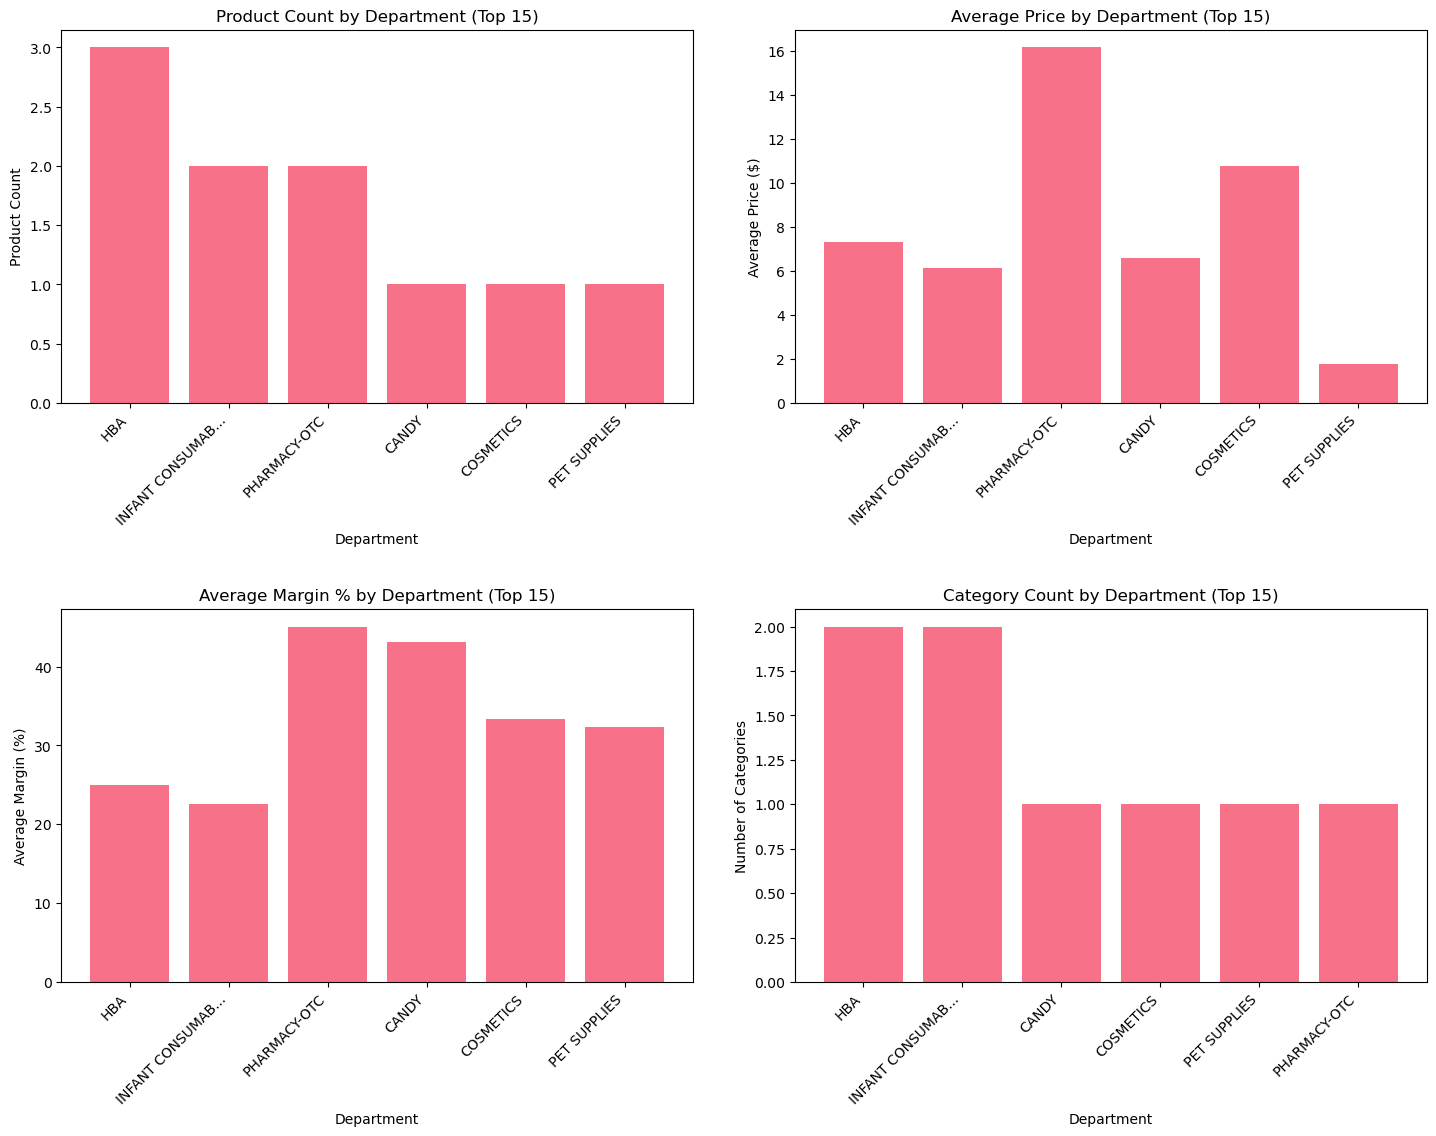

In [76]:
if 'dept_desc' in df.columns:
    dept_analysis = df.groupby('dept_desc').agg({
        'item_nbr': 'count',
        'base_unit_retail_amt': ['mean', 'median', 'std'] if 'base_unit_retail_amt' in df.columns else lambda x: None,
        'margin_percent': 'mean' if 'margin_percent' in df.columns else lambda x: None,
        'is_active': 'sum' if 'is_active' in df.columns else lambda x: None
    }).round(2)
    
    dept_analysis.columns = ['_'.join(col).strip() for col in dept_analysis.columns]
    dept_analysis = dept_analysis.sort_values(dept_analysis.columns[0], ascending=False)
    
    print("Department Analysis (Top 10):")
    print(dept_analysis.head(10))
    
    if all(col in df.columns for col in ['dept_desc', 'dept_category_desc']):
        category_breadth = df.groupby('dept_desc')['dept_category_desc'].nunique().sort_values(ascending=False)
        
        print(f"\nCategory Breadth Analysis (Categories per Department):")
        print(category_breadth.head(10))
        
        high_complexity = category_breadth[category_breadth > category_breadth.quantile(0.75)]
        low_complexity = category_breadth[category_breadth < category_breadth.quantile(0.25)]
        
        print(f"\nHigh Complexity Departments (>{category_breadth.quantile(0.75):.0f} categories):")
        print(high_complexity)
        
        print(f"\nLow Complexity Departments (<{category_breadth.quantile(0.25):.0f} categories):")
        print(low_complexity)
        
    if len(dept_analysis) > 0:
        print("\n📈 Generating Department Visualizations...")
        plt.figure(figsize=(15, 12))
        
        plt.subplot(2, 2, 1)
        top_depts = dept_analysis.head(15)
        plt.bar(range(len(top_depts)), top_depts.iloc[:, 0])
        plt.title('Product Count by Department (Top 15)')
        plt.xlabel('Department')
        plt.ylabel('Product Count')
        plt.xticks(range(len(top_depts)), [
            dept[:15] + '...' if len(dept) > 15 else dept 
            for dept in top_depts.index
        ], rotation=45, ha='right')
        
        if 'base_unit_retail_amt_mean' in dept_analysis.columns:
            plt.subplot(2, 2, 2)
            price_data = dept_analysis['base_unit_retail_amt_mean'].dropna().head(15)
            plt.bar(range(len(price_data)), price_data.values)
            plt.title('Average Price by Department (Top 15)')
            plt.xlabel('Department')
            plt.ylabel('Average Price ($)')
            plt.xticks(range(len(price_data)), [
                dept[:15] + '...' if len(dept) > 15 else dept 
                for dept in price_data.index
            ], rotation=45, ha='right')
            
        if 'margin_percent_mean' in dept_analysis.columns:
            plt.subplot(2, 2, 3)
            margin_data = dept_analysis['margin_percent_mean'].dropna().head(15)
            plt.bar(range(len(margin_data)), margin_data.values)
            plt.title('Average Margin % by Department (Top 15)')
            plt.xlabel('Department')
            plt.ylabel('Average Margin (%)')
            plt.xticks(range(len(margin_data)), [
                dept[:15] + '...' if len(dept) > 15 else dept 
                for dept in margin_data.index
            ], rotation=45, ha='right')
            
        if 'dept_category_desc' in df.columns and 'category_breadth' in locals():
            plt.subplot(2, 2, 4)
            complexity_data = category_breadth.head(15)
            plt.bar(range(len(complexity_data)), complexity_data.values)
            plt.title('Category Count by Department (Top 15)')
            plt.xlabel('Department')
            plt.ylabel('Number of Categories')
            plt.xticks(range(len(complexity_data)), [
                dept[:15] + '...' if len(dept) > 15 else dept 
                for dept in complexity_data.index
            ], rotation=45, ha='right')
        
        plt.tight_layout(pad=3.0)
        plt.show()

This block uses the `matplotlib` library to create charts based on the analysis from the first section. It generates two bar charts for the top 15 departments:
1.  **Product Count by Department**: Visually compares how many products each department has.
2.  **Average Price by Department**: Visually compares the average price point of products in each department.

Visualizations make the data easier to understand at a glance.

#### Portfolio Concentration

In [66]:
    # --- Portfolio Concentration (80/20 Analysis) ---
    print("\nAnalyzing portfolio concentration...")
    dept_counts = df['dept_desc'].value_counts()
    cumulative_percentage = dept_counts.cumsum() / dept_counts.sum() * 100
    top_depts_80pct = cumulative_percentage[cumulative_percentage <= 80]
    print(f"The top {len(top_depts_80pct)} departments ({len(top_depts_80pct)/len(dept_counts)*100:.1f}% of all depts) account for {top_depts_80pct.iloc[-1]:.1f}% of all products.")


Analyzing portfolio concentration...
The top 4 departments (66.7% of all depts) account for 80.0% of all products.


This section applies the Pareto principle (also known as the 80/20 rule) to the product portfolio. It calculates what percentage of departments account for 80% of the total products. This is a common business analysis to identify the "vital few" departments that make up the bulk of the company's offerings.


#### SKU Density Analysis

In [73]:
if all(col in df.columns for col in ['dept_desc', 'dept_category_desc', 'dept_subcatg_desc']):
    sku_density = df.groupby('dept_desc').agg({
        'dept_category_desc': 'nunique',
        'dept_subcatg_desc': 'nunique',
        'item_nbr': 'count'
    })
    sku_density.columns = ['Categories', 'Subcategories', 'SKUs']
    sku_density['SKUs_per_Category'] = (sku_density['SKUs'] / sku_density['Categories']).replace(np.inf, 0)
    sku_density['SKUs_per_Subcategory'] = (sku_density['SKUs'] / sku_density['Subcategories']).replace(np.inf, 0)
    
    print(f"\nSKU Density Analysis (Top 10 by SKU count):")
    sku_density_sorted = sku_density.sort_values('SKUs', ascending=False)
    print(sku_density_sorted.head(10).round(1))
    
    high_sku_density = sku_density[sku_density['SKUs_per_Category'] > sku_density['SKUs_per_Category'].quantile(0.75)]
    print(f"\nHigh SKU Proliferation Departments (Candidates for SKU rationalization):")
    print(high_sku_density.sort_values('SKUs_per_Category', ascending=False))


SKU Density Analysis (Top 10 by SKU count):
                    Categories  Subcategories  SKUs  SKUs_per_Category  \
dept_desc                                                                
HBA                          2              3     3                1.5   
INFANT CONSUMABLES           2              2     2                1.0   
PHARMACY-OTC                 1              2     2                2.0   
CANDY                        1              1     1                1.0   
COSMETICS                    1              1     1                1.0   
PET SUPPLIES                 1              1     1                1.0   

                    SKUs_per_Subcategory  
dept_desc                                 
HBA                                  1.0  
INFANT CONSUMABLES                   1.0  
PHARMACY-OTC                         1.0  
CANDY                                1.0  
COSMETICS                            1.0  
PET SUPPLIES                         1.0  

High SKU Prolifer

This part calculates the "density" of SKUs (Stock Keeping Units, or individual products) within each department's structure. It measures how many SKUs exist per category and subcategory. A high SKU density might indicate a deep assortment in a few areas, while a low density could mean a broader, more shallow assortment.

####  Department Strategic Classification

In [71]:
if all(col in df.columns for col in ['dept_desc', 'base_unit_retail_amt', 'margin_percent']):
    category_matrix = df.groupby('dept_desc').agg({
        'item_nbr': 'count',
        'base_unit_retail_amt': 'mean',
        'margin_percent': 'mean'
    }).round(2)
    
    category_matrix.columns = ['Product_Count', 'Avg_Price', 'Avg_Margin']
    
    high_volume_threshold = category_matrix['Product_Count'].median()
    high_margin_threshold = category_matrix['Avg_Margin'].median()
    
    def classify_department(row):
        is_high_volume = row['Product_Count'] > high_volume_threshold
        is_high_margin = row['Avg_Margin'] > high_margin_threshold
        if is_high_volume and is_high_margin:
            return 'Core Performers (High Volume, High Margin)'
        elif is_high_volume and not is_high_margin:
            return 'Volume Drivers (High Volume, Low Margin)'
        elif not is_high_volume and is_high_margin:
            return 'Niche Stars (Low Volume, High Margin)'
        else:
            return 'Underperformers (Low Volume, Low Margin)'
    
    category_matrix['Strategy_Classification'] = category_matrix.apply(classify_department, axis=1)
    
    print(f"\nDepartment Strategic Classification:")
    strategy_summary = category_matrix['Strategy_Classification'].value_counts()
    print(strategy_summary)
    
    print(f"\nExamples for each classification:")
    for strategy in strategy_summary.index:
        examples = category_matrix[category_matrix['Strategy_Classification'] == strategy].head(3)
        print(f"\n--- {strategy} ---")
        print(examples[['Product_Count', 'Avg_Price', 'Avg_Margin']])


Department Strategic Classification:
Strategy_Classification
Niche Stars (Low Volume, High Margin)         2
Volume Drivers (High Volume, Low Margin)      2
Underperformers (Low Volume, Low Margin)      1
Core Performers (High Volume, High Margin)    1
Name: count, dtype: int64

Examples for each classification:

--- Niche Stars (Low Volume, High Margin) ---
           Product_Count  Avg_Price  Avg_Margin
dept_desc                                      
CANDY                  1       6.58       43.16
COSMETICS              1      10.77       33.33

--- Volume Drivers (High Volume, Low Margin) ---
                    Product_Count  Avg_Price  Avg_Margin
dept_desc                                               
HBA                             3       7.31       24.99
INFANT CONSUMABLES              2       6.12       22.60

--- Underperformers (Low Volume, Low Margin) ---
              Product_Count  Avg_Price  Avg_Margin
dept_desc                                         
PET SUPPLIES    

This is a more advanced analytical step. It classifies each department into one of four strategic categories based on its product count (volume) and profit margin:
*   **Core Performers**: High volume and high margin. These are the most important departments.
*   **Volume Drivers**: High volume but low margin. They drive sales but aren't as profitable.
*   **Niche Stars**: Low volume but high margin. Specialized, profitable departments.
*   **Underperformers**: Low volume and low margin. These departments may need strategic review.

This helps in making strategic decisions about where to invest or divest.

Department Analysis (Top 10):
                    item_nbr_count  base_unit_retail_amt_mean  \
dept_desc                                                       
HBA                              3                       7.31   
INFANT CONSUMABLES               2                       6.12   
PHARMACY-OTC                     2                      16.17   
CANDY                            1                       6.58   
COSMETICS                        1                      10.77   
PET SUPPLIES                     1                       1.78   

                    base_unit_retail_amt_median  base_unit_retail_amt_std  \
dept_desc                                                                   
HBA                                        6.98                      2.02   
INFANT CONSUMABLES                         6.12                      5.44   
PHARMACY-OTC                              16.17                      3.11   
CANDY                                      6.58                 

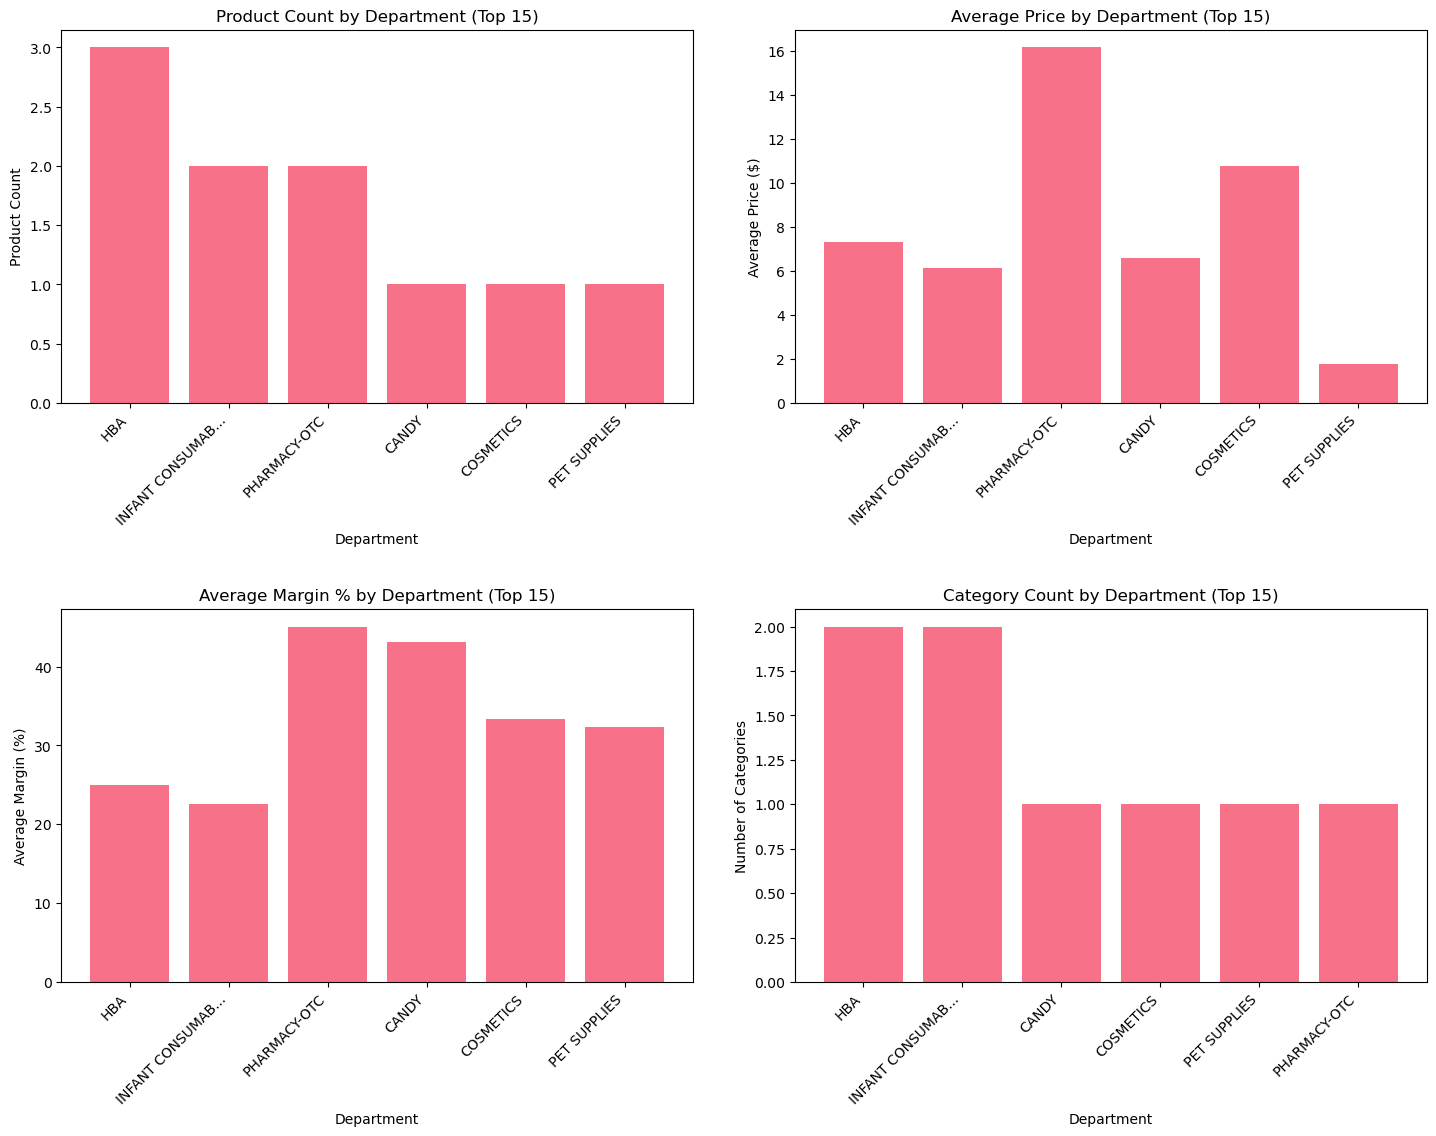


Portfolio Concentration Analysis (80/20 Rule):
  The top 4 departments (out of 6) account for 80.0% of all products.


In [74]:
if 'dept_desc' in df.columns:
    dept_analysis = df.groupby('dept_desc').agg({
        'item_nbr': 'count',
        'base_unit_retail_amt': ['mean', 'median', 'std'] if 'base_unit_retail_amt' in df.columns else lambda x: None,
        'margin_percent': 'mean' if 'margin_percent' in df.columns else lambda x: None,
        'is_active': 'sum' if 'is_active' in df.columns else lambda x: None
    }).round(2)
    
    dept_analysis.columns = ['_'.join(col).strip() for col in dept_analysis.columns]
    dept_analysis = dept_analysis.sort_values(dept_analysis.columns[0], ascending=False)
    
    print("Department Analysis (Top 10):")
    print(dept_analysis.head(10))
    
    if all(col in df.columns for col in ['dept_desc', 'dept_category_desc']):
        category_breadth = df.groupby('dept_desc')['dept_category_desc'].nunique().sort_values(ascending=False)
        
        print(f"\nCategory Breadth Analysis (Categories per Department):")
        print(category_breadth.head(10))
        
        high_complexity = category_breadth[category_breadth > category_breadth.quantile(0.75)]
        low_complexity = category_breadth[category_breadth < category_breadth.quantile(0.25)]
        
        print(f"\nHigh Complexity Departments (>{category_breadth.quantile(0.75):.0f} categories):")
        print(high_complexity)
        
        print(f"\nLow Complexity Departments (<{category_breadth.quantile(0.25):.0f} categories):")
        print(low_complexity)
        
    if len(dept_analysis) > 0:
        print("\n📈 Generating Department Visualizations...")
        plt.figure(figsize=(15, 12))
        
        plt.subplot(2, 2, 1)
        top_depts = dept_analysis.head(15)
        plt.bar(range(len(top_depts)), top_depts.iloc[:, 0])
        plt.title('Product Count by Department (Top 15)')
        plt.xlabel('Department')
        plt.ylabel('Product Count')
        plt.xticks(range(len(top_depts)), [
            dept[:15] + '...' if len(dept) > 15 else dept 
            for dept in top_depts.index
        ], rotation=45, ha='right')
        
        if 'base_unit_retail_amt_mean' in dept_analysis.columns:
            plt.subplot(2, 2, 2)
            price_data = dept_analysis['base_unit_retail_amt_mean'].dropna().head(15)
            plt.bar(range(len(price_data)), price_data.values)
            plt.title('Average Price by Department (Top 15)')
            plt.xlabel('Department')
            plt.ylabel('Average Price ($)')
            plt.xticks(range(len(price_data)), [
                dept[:15] + '...' if len(dept) > 15 else dept 
                for dept in price_data.index
            ], rotation=45, ha='right')
            
        if 'margin_percent_mean' in dept_analysis.columns:
            plt.subplot(2, 2, 3)
            margin_data = dept_analysis['margin_percent_mean'].dropna().head(15)
            plt.bar(range(len(margin_data)), margin_data.values)
            plt.title('Average Margin % by Department (Top 15)')
            plt.xlabel('Department')
            plt.ylabel('Average Margin (%)')
            plt.xticks(range(len(margin_data)), [
                dept[:15] + '...' if len(dept) > 15 else dept 
                for dept in margin_data.index
            ], rotation=45, ha='right')
            
        if 'dept_category_desc' in df.columns and 'category_breadth' in locals():
            plt.subplot(2, 2, 4)
            complexity_data = category_breadth.head(15)
            plt.bar(range(len(complexity_data)), complexity_data.values)
            plt.title('Category Count by Department (Top 15)')
            plt.xlabel('Department')
            plt.ylabel('Number of Categories')
            plt.xticks(range(len(complexity_data)), [
                dept[:15] + '...' if len(dept) > 15 else dept 
                for dept in complexity_data.index
            ], rotation=45, ha='right')
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
    total_products = len(df)
    dept_counts = df['dept_desc'].value_counts()
    
    cumulative_products = dept_counts.cumsum()
    cumulative_percentage = cumulative_products / total_products * 100
    
    top_depts_80pct = cumulative_percentage[cumulative_percentage <= 80]
    num_top_depts = len(top_depts_80pct)
    
    print(f"\nPortfolio Concentration Analysis (80/20 Rule):")
    print(f"  The top {num_top_depts} departments (out of {len(dept_counts)}) account for {top_depts_80pct.iloc[-1]:.1f}% of all products.")

#### Brand Level Analysis

In [80]:
# --- 1.1. National Brand (NB) vs. Private Label (PL) ---
print("\n🔍 1.1 Comparing National Brands vs. Private Labels...")
if 'brand_type' in df.columns:
    brand_type_summary = df.groupby('brand_type').agg(
        product_count=('item_nbr', 'nunique'),
        avg_price=('base_unit_retail_amt', 'mean'),
        avg_margin_pct=('margin_pct', 'mean')
    ).round(2)
    print("This table shows a high-level comparison of performance between your private labels and national brands:")
    print(brand_type_summary)
else:
    print("Skipped: 'brand_type' column not found.")

# --- 1.2. Top 5 Performing Brands ---
print("\n🏆 1.2 Identifying Top 5 Brands by different metrics...")
if 'brand_name' in df.columns:
    # Top 5 Brands by Product Count
    top_5_by_count = df.groupby('brand_name')['item_nbr'].nunique().nlargest(5)
    print("\nThese brands have the largest number of unique products in the assortment:")
    print(top_5_by_count)

    # Top 5 Brands by Average Price
    top_5_by_price = df.groupby('brand_name')['base_unit_retail_amt'].mean().nlargest(5)
    print("\nThese are your most premium brands on average:")
    print(top_5_by_price.round(2))

    # Top 5 Brands by Average Profit Margin
    top_5_by_margin = df.groupby('brand_name')['margin_pct'].mean().nlargest(5)
    print("\nThese brands generate the highest average profit margin per product:")
    print(top_5_by_margin.round(2))
else:
    print("Skipped: 'brand_name' column not found.")

# --- 1.3. Brand Concentration (80/20 Rule) ---
print("\n📈 1.3 Calculating Brand Concentration (Pareto Principle)...")
if 'brand_name' in df.columns:
    brand_counts = df['brand_name'].value_counts()
    cumulative_pct = brand_counts.cumsum() / brand_counts.sum() * 100
    # Find the number of brands that make up 80% of the products
    brands_for_80_pct = cumulative_pct[cumulative_pct <= 80].count() + 1
    total_brands = df['brand_name'].nunique()
    print(f"This analysis shows your dependency on top brands.")
    print(f"Out of {total_brands} total brands, the top {brands_for_80_pct} brands make up ~80% of your product assortment.")
else:
    print("Skipped: 'brand_name' column not found.")


🔍 1.1 Comparing National Brands vs. Private Labels...
This table shows a high-level comparison of performance between your private labels and national brands:
            product_count  avg_price  avg_margin_pct
brand_type                                          
NB                      9       9.32           31.87
PL                      1       1.78           32.40

🏆 1.2 Identifying Top 5 Brands by different metrics...

These brands have the largest number of unique products in the assortment:
brand_name
D-KOHL & FRISCH    2
D-NIVEA MEN        1
D-POLIDENT         1
D-SALLY HANSEN     1
D-SENSODYNE        1
Name: item_nbr, dtype: int64

These are your most premium brands on average:
brand_name
D-KOHL & FRISCH    16.17
D-SALLY HANSEN     10.77
E-DESITIN           9.97
D-POLIDENT          9.47
D-SENSODYNE         6.98
Name: base_unit_retail_amt, dtype: float64

These brands generate the highest average profit margin per product:
brand_name
D-KOHL & FRISCH       45.07
E-SMARTIES     

Compares Brand Types: It analyzes the performance of National Brands vs. Private Label brands by looking at key metrics like the number of unique products, average price, and average profit margin for each category.
Identifies Key Brands: The script pinpoints the most important brands in your assortment by ranking them by product count and profitability, and it calculates brand concentration to see how many brands make up 80% of your products.

#### Vendor Analysis

In [81]:
if 'vendor_name' in df.columns:
    # --- 2.1. Top 10 Vendors by SKU Count ---
    print("\n🔍 2.1 Identifying Top 10 Vendors by number of products supplied...")
    top_10_vendors = df.groupby('vendor_name')['item_nbr'].nunique().nlargest(10)
    print("These are your largest suppliers based on the number of unique products they provide:")
    print(top_10_vendors)

    # --- 2.2. Vendor Profitability ---
    print("\n💰 2.2 Analyzing Vendor Profitability...")
    # Calculate average margin and product count for each vendor
    vendor_profitability = df.groupby('vendor_name').agg(
        product_count=('item_nbr', 'nunique'),
        avg_margin_pct=('margin_pct', 'mean')
    ).round(2)
    # Show profitability for the Top 10 vendors by count
    top_vendors_profit = vendor_profitability.loc[top_10_vendors.index].sort_values(by='avg_margin_pct', ascending=False)
    print("This table shows the average profit margin for your top 10 largest vendors.")
    print("It helps answer: Are your biggest vendors also your most profitable?")
    print(top_vendors_profit)

    # --- 2.3. Vendor vs. Brand Mapping ---
    print("\n🗺️ 2.3 Mapping which vendors supply which brand types (National vs. Private)...")
    vendor_brand_mapping = pd.crosstab(df['vendor_name'], df['brand_type'])
    # Filter for vendors who supply both or a significant number of items
    significant_vendors_map = vendor_brand_mapping.loc[top_10_vendors.index]
    print("This table shows how many National Brand (NB) and Private Label (PL) products your top vendors supply.")
    print("It can reveal if a single vendor is responsible for your private label program.")
    print(significant_vendors_map)
else:
    print("Skipped: 'vendor_name' column not found.")

print("\n\n✅ Analysis Complete.")


🔍 2.1 Identifying Top 10 Vendors by number of products supplied...
These are your largest suppliers based on the number of unique products they provide:
vendor_name
HALEON CANADA ULC                 2
KOHL & FRISCH LTD                 2
BABY GOURMET FOODS INC            1
BEIERSDORF CANADA INC             1
HFC PRESTIGE INTERNATIONAL CAN    1
KENVUE CANADA INC                 1
MENU FOODS LTD                    1
NESTLE CANADA INC.                1
Name: item_nbr, dtype: int64

💰 2.2 Analyzing Vendor Profitability...
This table shows the average profit margin for your top 10 largest vendors.
It helps answer: Are your biggest vendors also your most profitable?
                                product_count  avg_margin_pct
vendor_name                                                  
KOHL & FRISCH LTD                           2           45.07
NESTLE CANADA INC.                          1           43.16
HFC PRESTIGE INTERNATIONAL CAN              1           33.33
MENU FOODS LTD       

In [ ]:
Compares Brand Types: It analyzes the performance of National Brands vs. Private Label brands by looking at key metrics like the number of unique products, average price, and average profit margin for each category.
Identifies Key Brands: The script pinpoints the most important brands in your assortment by ranking them by product count and profitability, and it calculates brand concentration to see how many brands make up 80% of your products.

#### Vendor Analysis

In [78]:
if 'vendor_name' in df.columns:
    # --- 2.1. Top 10 Vendors by SKU Count ---
    print("\n🔍 2.1 Identifying Top 10 Vendors by number of products supplied...")
    top_10_vendors = df.groupby('vendor_name')['item_nbr'].nunique().nlargest(10)
    print("These are your largest suppliers based on the number of unique products they provide:")
    print(top_10_vendors)

    # --- 2.2. Vendor Profitability ---
    print("\n💰 2.2 Analyzing Vendor Profitability...")
    # Calculate average margin and product count for each vendor
    vendor_profitability = df.groupby('vendor_name').agg(
        product_count=('item_nbr', 'nunique'),
        avg_margin_pct=('margin_pct', 'mean')
    ).round(2)
    # Show profitability for the Top 10 vendors by count
    top_vendors_profit = vendor_profitability.loc[top_10_vendors.index].sort_values(by='avg_margin_pct', ascending=False)
    print("This table shows the average profit margin for your top 10 largest vendors.")
    print("It helps answer: Are your biggest vendors also your most profitable?")
    print(top_vendors_profit)

    # --- 2.3. Vendor vs. Brand Mapping ---
    print("\n🗺️ 2.3 Mapping which vendors supply which brand types (National vs. Private)...")
    vendor_brand_mapping = pd.crosstab(df['vendor_name'], df['brand_type'])
    # Filter for vendors who supply both or a significant number of items
    significant_vendors_map = vendor_brand_mapping.loc[top_10_vendors.index]
    print("This table shows how many National Brand (NB) and Private Label (PL) products your top vendors supply.")
    print("It can reveal if a single vendor is responsible for your private label program.")
    print(significant_vendors_map)
else:
    print("Skipped: 'vendor_name' column not found.")

print("\n\n✅ Analysis Complete.")


🔍 2.1 Identifying Top 10 Vendors by number of products supplied...
These are your largest suppliers based on the number of unique products they provide:
vendor_name
HALEON CANADA ULC                 2
KOHL & FRISCH LTD                 2
BABY GOURMET FOODS INC            1
BEIERSDORF CANADA INC             1
HFC PRESTIGE INTERNATIONAL CAN    1
KENVUE CANADA INC                 1
MENU FOODS LTD                    1
NESTLE CANADA INC.                1
Name: item_nbr, dtype: int64

💰 2.2 Analyzing Vendor Profitability...
This table shows the average profit margin for your top 10 largest vendors.
It helps answer: Are your biggest vendors also your most profitable?
                                product_count  avg_margin_pct
vendor_name                                                  
KOHL & FRISCH LTD                           2           45.07
NESTLE CANADA INC.                          1           43.16
HFC PRESTIGE INTERNATIONAL CAN              1           33.33
MENU FOODS LTD       